In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

In [2]:
import kagglehub

path = kagglehub.dataset_download("arshkon/linkedin-job-postings")
data = pd.read_csv(path + "/postings.csv")
data.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


<Axes: >

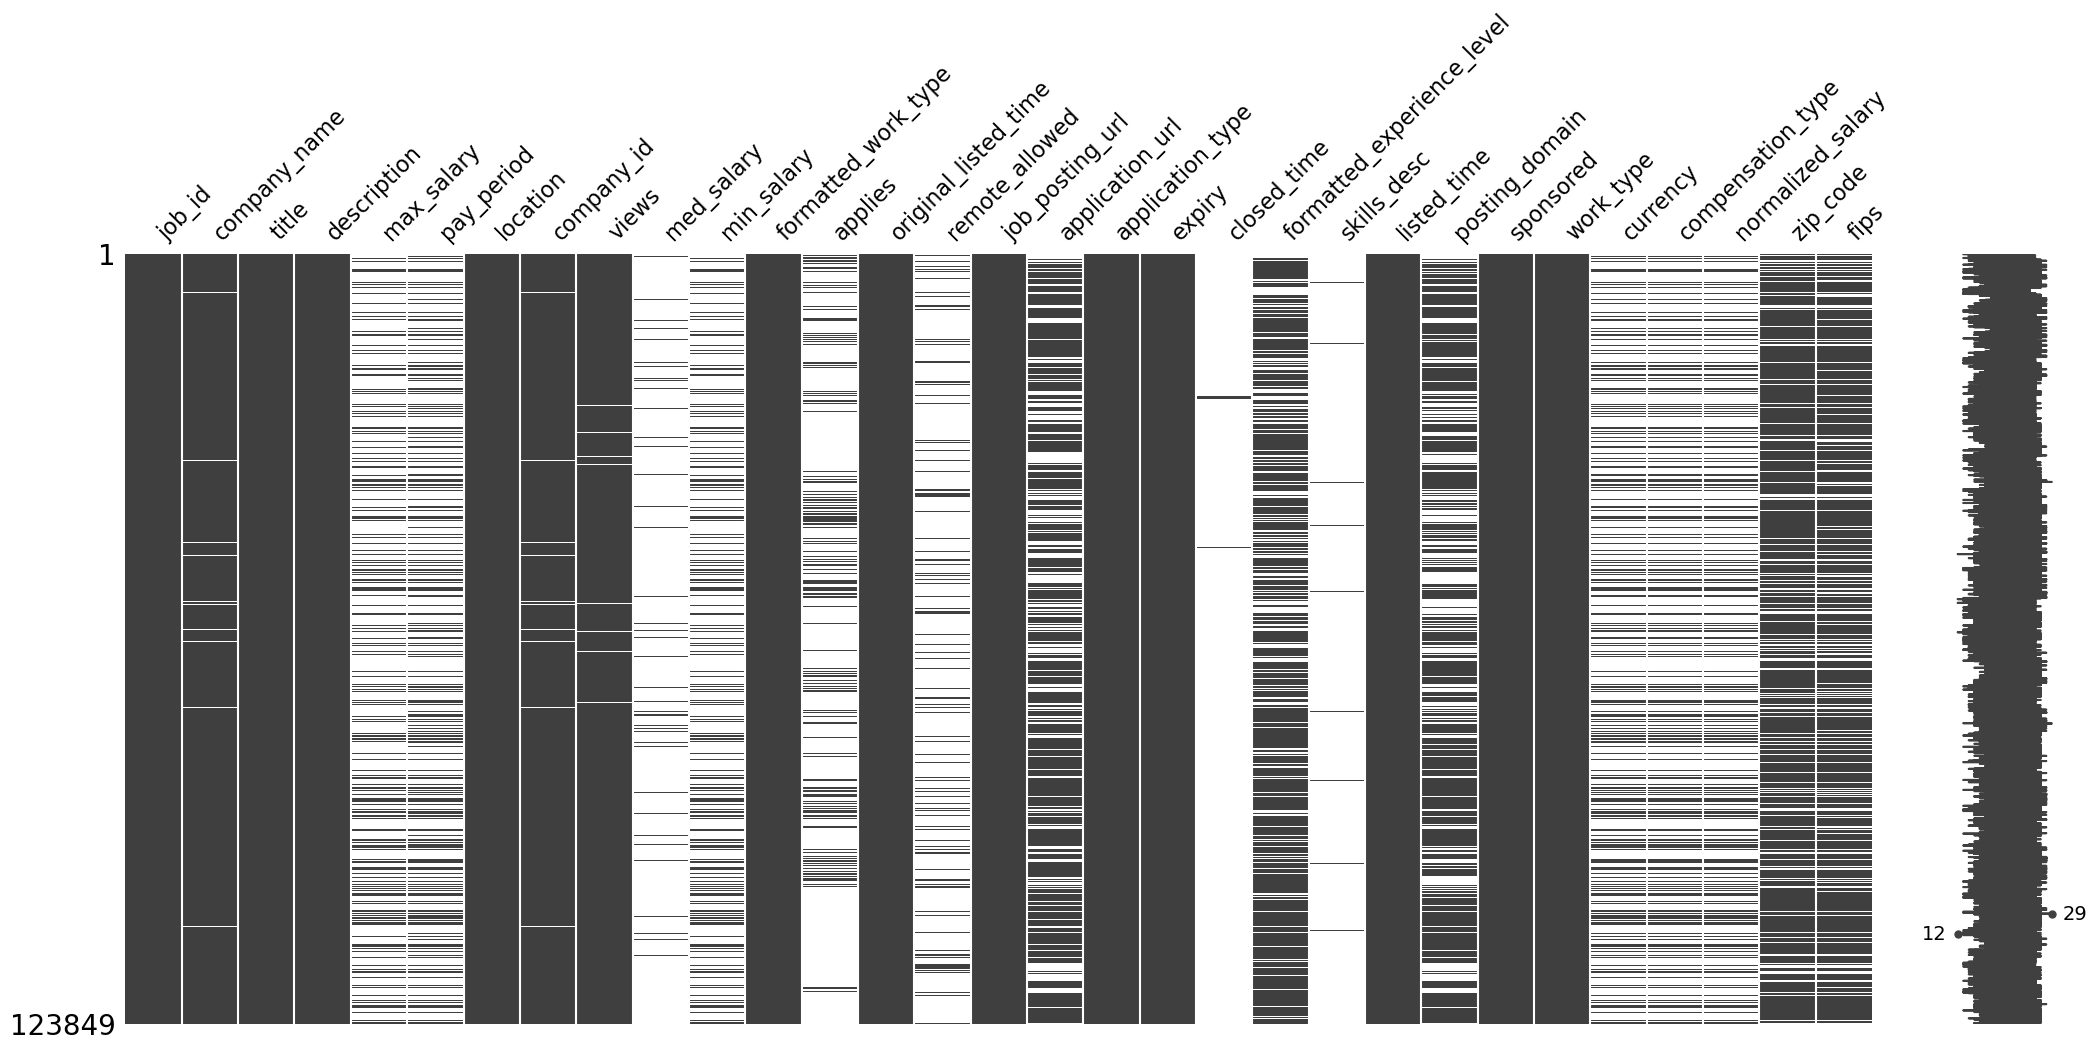

In [3]:
import missingno as msno
msno.matrix(data)

In [4]:
data.isna().sum()

job_id                             0
company_name                    1719
title                              0
description                        7
max_salary                     94056
pay_period                     87776
location                           0
company_id                      1717
views                           1689
med_salary                    117569
min_salary                     94056
formatted_work_type                0
applies                       100529
original_listed_time               0
remote_allowed                108603
job_posting_url                    0
application_url                36665
application_type                   0
expiry                             0
closed_time                   122776
formatted_experience_level     29409
skills_desc                   121410
listed_time                        0
posting_domain                 39968
sponsored                          0
work_type                          0
currency                       87776
c

In [5]:
data = data[data['description'].notna()]
data.isna().sum()

job_id                             0
company_name                    1718
title                              0
description                        0
max_salary                     94050
pay_period                     87770
location                           0
company_id                      1716
views                           1689
med_salary                    117562
min_salary                     94050
formatted_work_type                0
applies                       100524
original_listed_time               0
remote_allowed                108599
job_posting_url                    0
application_url                36658
application_type                   0
expiry                             0
closed_time                   122771
formatted_experience_level     29402
skills_desc                   121403
listed_time                        0
posting_domain                 39961
sponsored                          0
work_type                          0
currency                       87770
c

In [6]:
output_path = "postings_dataset.jsonl"

with open(output_path, "w") as f:
    f.write(data.to_json(orient='records', lines=True))

## Document Embeddings

In [7]:
from sentence_transformers import SentenceTransformer, util

model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

In [8]:
embeddings = []
docids = []
for i in tqdm(range(len(data))):
    embeddings.append(model.encode(data.iloc[i]['description']).reshape(1, -1))
    docids.append(data.iloc[i]['job_id'])

100%|██████████| 123842/123842 [50:08<00:00, 41.16it/s] 


In [9]:
embeddings = np.squeeze(embeddings)
np.save("description_embeddings.all-MiniLM-L6-v2.npy", embeddings)

In [10]:
with open("job_posting_ids.txt", 'w') as f:
    for docid in docids:
        f.write(str(docid) + "\n")

## Document Augmentation

In [11]:
import importlib
import sys
# importlib.reload(sys.modules['document_augmentation'])
from document_augmentation import DocSummaryGenerator

In [12]:
print('loading model1...')
model1 = DocSummaryGenerator("google-t5/t5-small")
print('loading model2...')
model2 = DocSummaryGenerator("google-t5/t5-base")
print('loading model3...')
model3 = DocSummaryGenerator("google-t5/t5-large")
print('loading model4...')
model4 = DocSummaryGenerator("facebook/bart-large-cnn")

model1_time = []
model2_time = []
model3_time = []
model4_time = []

model1_queries = []
model2_queries = []
model3_queries = []
model4_queries = []

loading model1...
loading model2...
loading model3...
loading model4...


In [13]:
prefix_prompt = 'summarize: '

print('generating queries...')
for i in tqdm(range(10)):
    # print("model1 processing...")
    start = time.time()
    model1_queries.append(model1.get_summary(data.iloc[i]['description'], prefix_prompt=prefix_prompt))
    end = time.time()
    model1_time.append(end - start)

    # print("model2 processing...")
    start = time.time()
    model2_queries.append(model2.get_summary(data.iloc[i]['description'], prefix_prompt=prefix_prompt))
    end = time.time()
    model2_time.append(end - start)

    # print("model3 processing...")
    start = time.time()
    model3_queries.append(model3.get_summary(data.iloc[i]['description'], prefix_prompt=prefix_prompt))
    end = time.time()
    model3_time.append(end - start)

    # print("model4 processing...")
    start = time.time()
    model4_queries.append(model4.get_summary(data.iloc[i]['description']))
    end = time.time()
    model4_time.append(end - start)

generating queries...


100%|██████████| 10/10 [02:31<00:00, 15.20s/it]


In [14]:
index = 5
data.iloc[index]["description"]

'Job summary:The Economic Development & Planning Intern will provide valuable support to the Economic Development & Planning team, with a specific focus on urban planning and transportation initiatives during the upcoming summer semester. This role is ideal for a local graduate or undergraduate student with a keen interest in economic development, city planning, and a passion for contributing to the growth of a vibrant downtown community.\nResponsibilities/Essential Functions:Support the Planning & Transportation Manager and DRA Economic Development &Planning team in major planning and advocacy initiatives, such as the ongoing Downtown Economic Development Strategy.Assist in coordination efforts related to transportation planning and major downtownprojects such Raleigh’s first Bus Rapid Transit line.Contribute to the creation of reports, including the annual State of Downtown andquarterly market reports.Assist in data collection, analysis, and maintenance of downtown data.Support small

In [15]:
model1_queries[index], model2_queries[index], model3_queries[index], model4_queries[index]

('a job summary is offered by the Economic Development & Planning Intern. the role aims to help people find a path up to a higher education level.',
 'the Economic Development & Planning Intern will provide valuable support for the economic development & planning team during the summer semester . the position is ideal for a local graduate or undergraduate student with a keen interest in urbandevelopment and city planning . this is an in-person role with the candidate reporting to the downtown Raleigh Alliance offices.',
 'the role is ideal for a local graduate or undergraduate student seeking hands-on experience in city planning and economic development . requirements include: strong interest in economic development and community revitalization.',
 'The Economic Development & Planning Intern will provide valuable support to the Economic Development and Planning team during the upcoming summer semester. This role is ideal for a local graduate or undergraduate student with a keen interes

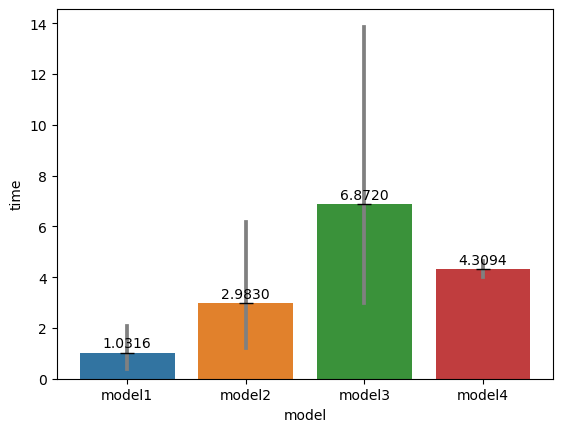

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
df = []
for i in range(10):
    df.append({'model': 'model1', 'time': model1_time[i]})
    df.append({'model': 'model2', 'time': model2_time[i]})
    df.append({'model': 'model3', 'time': model3_time[i]})
    df.append({'model': 'model4', 'time': model4_time[i]})
    
df = pd.DataFrame(df)
ax = sns.barplot(x='model', y='time', data=df, errcolor="grey")
model_avg = [np.mean(model1_time), np.mean(model2_time), np.mean(model3_time), np.mean(model4_time)]
for i, v in enumerate(model_avg):
    ax.text(i, v+0.2, "{:.4f}".format(v), ha='center', color='black')
    ax.plot(i, v, "_", markersize=10, color="black")
# plt.savefig(FIG_PATH + 'document_augmentation_time.png')

In [17]:
df = []
for i in range(10):
    df.append({
        'docid': data.iloc[i]['job_id'],
        'model 1': model1_queries[i],
        'model 2': model2_queries[i],
        'model 3': model3_queries[i],
        'model 4': model4_queries[i]
    })
df = pd.DataFrame(df)
df.to_csv('augmented__list.csv')
df.head(10)

,docid,model 1,model 2,model 3,model 4
0,921716,is an opportunity to be part of a fast-growing...,the position is part of a rapid-growing real e...,New jersey-based real estate firm is seeking a...,A leading real estate firm in New Jersey is se...
1,1829192,aspen therapy and Wellness focuses on protecti...,therapist is ready to offer full time job at n...,"aspen therapy and wellness, a group practice i...",Aspen Therapy and Wellness is a new group prac...
2,10998357,the National Exemplar accepts applications for...,nationalexemplar is accepting applications for...,the national Exemplar is accepting application...,The National Exemplar is accepting application...
3,23221523,"newly founded in 2000, the firm offers the leg...",the successful candidate will have strong comm...,Lake success-based law firm seeking associate ...,We are a prominent law firm based in New York ...
4,35982263,flying can send out the call on 1-800-446-1775...,"service tech, must be able to work in HVAC ind...",minimum 5 yrs of experience on the job with me...,Looking for HVAC service tech with experience ...
5,91700727,a job summary is offered by the Economic Devel...,the Economic Development & Planning Intern wil...,the role is ideal for a local graduate or unde...,The Economic Development & Planning Intern wil...
6,103254301,the name of the company Description was posted...,our mission is to push boundaries and create u...,Raw cereal is a creative design agency special...,Raw Cereal is a creative design agency special...
7,112576855,the Pacific-Union Club is one of the most excl...,we are seeking a Building Engineer at the Paci...,the Pacific-Union Club is one of the oldest an...,"The Building Engineer is a salaried, overtime-..."
8,1218575,children's is committed to diversity and inclu...,children's pediatric healthcare center is comm...,"in this role, a respiratory therapist provides...",Children's is committed to diversity and inclu...
9,2264355,the ideal candidate for the position is for so...,"a life long, faithful relationship with Jesus ...",this is an exciting time to be a part of our c...,The ideal candidate will invest their lives as...


### Generate summarization for all documents

Since augmenting all the documents takes extremely long time, we distribute them into 51 fractions to process separately.

In [18]:
FRACTION = 0.025
LENGTH = len(data)
PARTS = [int(LENGTH * (frac+1) / 100) for frac in range(0, 100, int(FRACTION * 100))]
aug_parts = np.split(data.sample(frac=1, random_state=10), PARTS)

/home/peichi/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [19]:
aug_docid = []
for i, docs in enumerate(aug_parts):
    aug_docid.append({
        "docid": docs['job_id'].to_list()
    })

In [20]:
aug_docid = pd.DataFrame(aug_docid)
output_path = "augment_docids.jsonl"
with open(output_path, "w") as f:
    f.write(aug_docid.to_json(orient='records', lines=True))

Run `document_augmentation.py` for each fraction, and use below to check if all the fractions has been ran.

In [21]:
INDEX = 15

In [22]:
ref = np.load('description_embeddings.all-MiniLM-L6-v2.npy')
new = np.load('augmented_description_embeddings.all-MiniLM-L6-v2.npy')

In [23]:
ids = []
for i in range(INDEX):
    ids += aug_docid.iloc[i]["docid"]
len(ids)

35914

In [24]:
cnt = 0
c = [False for _ in range(INDEX)]
for i in range(len(ref)):
    if (ref[i] != new[i]).any() and (docids[i] in ids):
        cnt += 1
        for j in range(INDEX):
            if not c[j]:
                if docids[i] in aug_docid.iloc[j]["docid"]:
                    c[j] = True
cnt, c

(6436,
 [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True])

We successfully ran augmented 23529 documents (15 fractions).

## Skill Extraction and Embeddings

In [25]:
from sentence_transformers import SentenceTransformer, util
import spacy

model_name = 'sentence-transformers/all-MiniLM-L6-v2'
skill_pattern_path = "jz_skill_patterns.jsonl"
model = SentenceTransformer(model_name)
nlp = spacy.load("en_core_web_lg")
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)

/home/peichi/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [26]:
def get_skills(text):
    doc = nlp(text)
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    # subset = list(set(subset)))
    skills_sentence = " ".join(subset)
    return skills_sentence

In [27]:
posting_skill_embeddings = []
docids = []
for i in tqdm(range(len(data))):
    skills_sentence = get_skills(data.iloc[i]['description'])
    posting_skill_embeddings.append(model.encode(skills_sentence).reshape(1, -1))
    docids.append(data.iloc[i]['job_id'])

100%|██████████| 123842/123842 [3:24:22<00:00, 10.10it/s]  


In [28]:
posting_skill_embeddings = np.array(posting_skill_embeddings)
np.save("skills_embeddings.npy", posting_skill_embeddings)